In [ ]:
import re
import os
import csv
import math
from collections import defaultdict, Counter
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


## Cargar nodos desde los CSV generados en Requerimiento 3

In [ ]:


path_cat = "../../proyecto/requerimiento3/frecuencias_palabras_categoria.csv"
path_top15 = "../../proyecto/requerimiento3/top15_palabras_frecuentes.csv"

# Helper para leer columna de palabras (intenta varias columnas/formatos)
def read_terms_from_csv(path, possible_cols=None):
    df = pd.read_csv(path)
    if possible_cols is None:
        possible_cols = df.columns.tolist()
    # busca la primera columna que parezca contener texto de términos
    for col in possible_cols:
        if df[col].dtype == object:
            terms = df[col].dropna().astype(str).tolist()
            if len(terms) > 0:
                return terms
    # fallback: tomar todo como strings
    return df.astype(str).stack().unique().tolist()

terms_cat = read_terms_from_csv(path_cat)
terms_top15 = read_terms_from_csv(path_top15)

# Unir, normalizar y quitar duplicados (preservando frases)
def normalize_term(t):
    t = t.strip().lower()
    t = t.replace('-', ' ')  # fine-tuning -> fine tuning
    t = re.sub(r'\s+', ' ', t)
    return t

terms_set = [normalize_term(t) for t in (terms_cat + terms_top15)]
# eliminar duplicados preservando orden
seen = set()
terms = []
for t in terms_set:
    if t not in seen and t != "":
        seen.add(t)
        terms.append(t)

print(f"Loaded {len(terms_cat)} terms from category CSV, {len(terms_top15)} from top15.")
print(f"Total unique candidate terms (nodes): {len(terms)}")
print("Example terms:", terms[:20])


Loaded 15 terms from category CSV, 15 from top15.
Total unique candidate terms (nodes): 30
Example terms: ['machine learning', 'privacy', 'generative models', 'training data', 'transparency', 'ethics', 'explainability', 'personalization', 'prompting', 'algorithmic bias', 'multimodality', 'fine tuning', 'human ai interaction', 'ai literacy', 'co creation', 'data', 'learning', 'model', 'generative', 'models']


## Reconstruimos a partir de consolidado.bib (misma limpieza usada antes). en el requerimiento 3

In [ ]:


try:
    abstracts_limpios  # si existe en memoria se usa
    print("Using existing 'abstracts_limpios' from memoria.")
except NameError:
    # Si no existe, leemos el .bib y limpiamos
    import bibtexparser
    ruta_bib = "consolidado.bib"  # ajusta si está en otra carpeta
    with open(ruta_bib, encoding="utf-8") as bibtex_file:
        bib_database = bibtexparser.load(bibtex_file)
    raw_abstracts = [entry["abstract"] for entry in bib_database.entries if "abstract" in entry]
    print(f"Found {len(raw_abstracts)} raw abstracts in .bib")
    # misma función de limpieza que antes (puedes ajustarla)
    import nltk
    nltk.download('stopwords', quiet=True)
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words("english"))
    def limpiar_texto_simple(texto):
        texto = (texto or "").lower()
        texto = re.sub(r'[^a-z0-9\s\-]', ' ', texto)  # permitimos numeros y guiones temporalmente
        texto = texto.replace('-', ' ')
        texto = re.sub(r'\s+', ' ', texto).strip()
        return texto
    abstracts_limpios = [limpiar_texto_simple(a) for a in raw_abstracts]
    # filtrar vacíos
    filtered = [(a,t) for a,t in zip(abstracts_limpios, [entry.get("title","") for entry in bib_database.entries if "abstract" in entry]) if a.strip() != ""]
    abstracts_limpios = [a for a,t in filtered]
    print(f"{len(abstracts_limpios)} abstracts remain after cleaning/filtering.")


Found 9443 raw abstracts in .bib
9402 abstracts remain after cleaning/filtering.
9402 abstracts remain after cleaning/filtering.


## CELDA 4: construcción automática del grafo de coocurrencia
### Reglas:
    - Nodo por término en `terms` (frases o palabras).
    - Dos términos conectados si aparecen juntos en al menos un documento.
    - Arista con peso = número de documentos donde coocurren.

In [ ]:

# Precompilación de patrones para buscar términos (coinciende palabras completas)
term_patterns = []
for t in terms:
    # escapamos y usamos r'\b' para bordes de palabra, pero si t contiene espacios (frase) lo usamos tal cual
    pat = r'\b' + re.escape(t) + r'\b'
    term_patterns.append((t, re.compile(pat, flags=re.IGNORECASE)))

# Data structures
G = nx.Graph()
G.add_nodes_from(terms)  # nodos etiquetados por el término normalizado

# contador de coocurrencias (edge weights)
edge_weights = Counter()

# contador de presencia por término (para ver en cuántos documentos aparece cada término)
term_doc_count = Counter()

# Para cada documento, detectamos qué términos aparecen (lista única por doc)
for doc_idx, doc in enumerate(abstracts_limpios):
    found = []
    for term, pattern in term_patterns:
        if pattern.search(doc):
            found.append(term)
            term_doc_count[term] += 1
    # todas las combinaciones de pares (undirected)
    for i in range(len(found)):
        for j in range(i+1, len(found)):
            a = found[i]
            b = found[j]
            if a == b: 
                continue
            # orden canonical para la llave
            key = tuple(sorted((a,b)))
            edge_weights[key] += 1

# Agregar aristas al grafo con atributo 'weight'
for (a,b), w in edge_weights.items():
    G.add_edge(a, b, weight=w)

# Quitar nodos aislados si deseas (opcional). Aquí mantengo todos, pero puedes filtrar:
G.remove_nodes_from(list(nx.isolates(G)))

print(f"Graph built: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges.")


Graph built: 30 nodes, 387 edges.


## Grado de cada nodo y componentes conexas

In [5]:
# CELDA 5: grado de cada nodo y componentes conexas

# grado (número de vecinos). Para grafo no ponderado:
degree_dict = dict(G.degree())  # grado simple
# también grado ponderado por peso:
weighted_degree = {n: sum(d.get('weight',1) for _,_,d in G.edges(n, data=True)) for n in G.nodes()}

# crear dataframe resumen
df_nodes = pd.DataFrame({
    "term": list(G.nodes()),
    "degree": [degree_dict[t] for t in G.nodes()],
    "weighted_degree": [weighted_degree[t] for t in G.nodes()],
    "doc_frequency": [term_doc_count.get(t, 0) for t in G.nodes()]  # en cuántos abstracts aparece
}).sort_values(by=["degree","weighted_degree"], ascending=False)

# componentes conexas
components = list(nx.connected_components(G))
comp_list = []
for comp_id, comp in enumerate(components, start=1):
    for term in comp:
        comp_list.append({"term": term, "component_id": comp_id, "component_size": len(comp)})

df_components = pd.DataFrame(comp_list)

# merge resumen
df_summary = df_nodes.merge(df_components, on="term", how="left").sort_values(by=["component_size","degree"], ascending=[False,False])

# Guardar CSVs de salida
out_dir = "datas"
os.makedirs(out_dir, exist_ok=True)

# Renombrar columnas al español para el CSV de resumen de nodos
df_summary_es = df_summary.rename(columns={
    'term':'termino',
    'degree':'grado',
    'weighted_degree':'grado_ponderado',
    'doc_frequency':'frecuencia_documentos',
    'component_id':'componente_id',
    'component_size':'tamano_componente'
})

resumen_path = os.path.join(out_dir, "resumen_nodos_coocurrencia.csv")
df_summary_es.to_csv(resumen_path, index=False, encoding='utf-8')

# También guardar la lista de aristas con peso (columnas en español)
edges_out = pd.DataFrame([{'term_a':a, 'term_b':b, 'weight':w} for (a,b),w in edge_weights.items()])
edges_out_es = edges_out.rename(columns={'term_a':'termino_a','term_b':'termino_b','weight':'peso'})
edges_path = os.path.join(out_dir, "lista_aristas_coocurrencia.csv")
edges_out_es.to_csv(edges_path, index=False, encoding='utf-8')

# Guardar el grafo completo en formato GraphML para que pueda reutilizarse en Gephi u otras herramientas
graphml_path = os.path.join(out_dir, "grafo_coocurrencia.graphml")
nx.write_graphml(G, graphml_path)

print("Resumen de nodos guardado en:", resumen_path)
print("Lista de aristas guardada en:", edges_path)
print("Grafo completo guardado en:", graphml_path)
print(f"Se encontraron {len(components)} componentes conexas (incluidos posibles nodos aislados).")


Resumen de nodos guardado en: datas\resumen_nodos_coocurrencia.csv
Lista de aristas guardada en: datas\lista_aristas_coocurrencia.csv
Grafo completo guardado en: datas\grafo_coocurrencia.graphml
Se encontraron 1 componentes conexas (incluidos posibles nodos aislados).


## Mostramos el Grafo

Resumen - top términos por grado:


,term,degree,weighted_degree,doc_frequency,component_id,component_size
0,generative,29,31091,5398,1,30
1,learning,29,27113,4603,1,30
2,data,29,26713,4472,1,30
3,model,29,26055,4306,1,30
4,paper,29,21283,3786,1,30
5,using,29,19107,3186,1,30
6,intelligence,29,17203,3513,1,30
7,image,29,16860,2620,1,30
8,privacy,29,3520,576,1,30
9,models,28,21433,3609,1,30


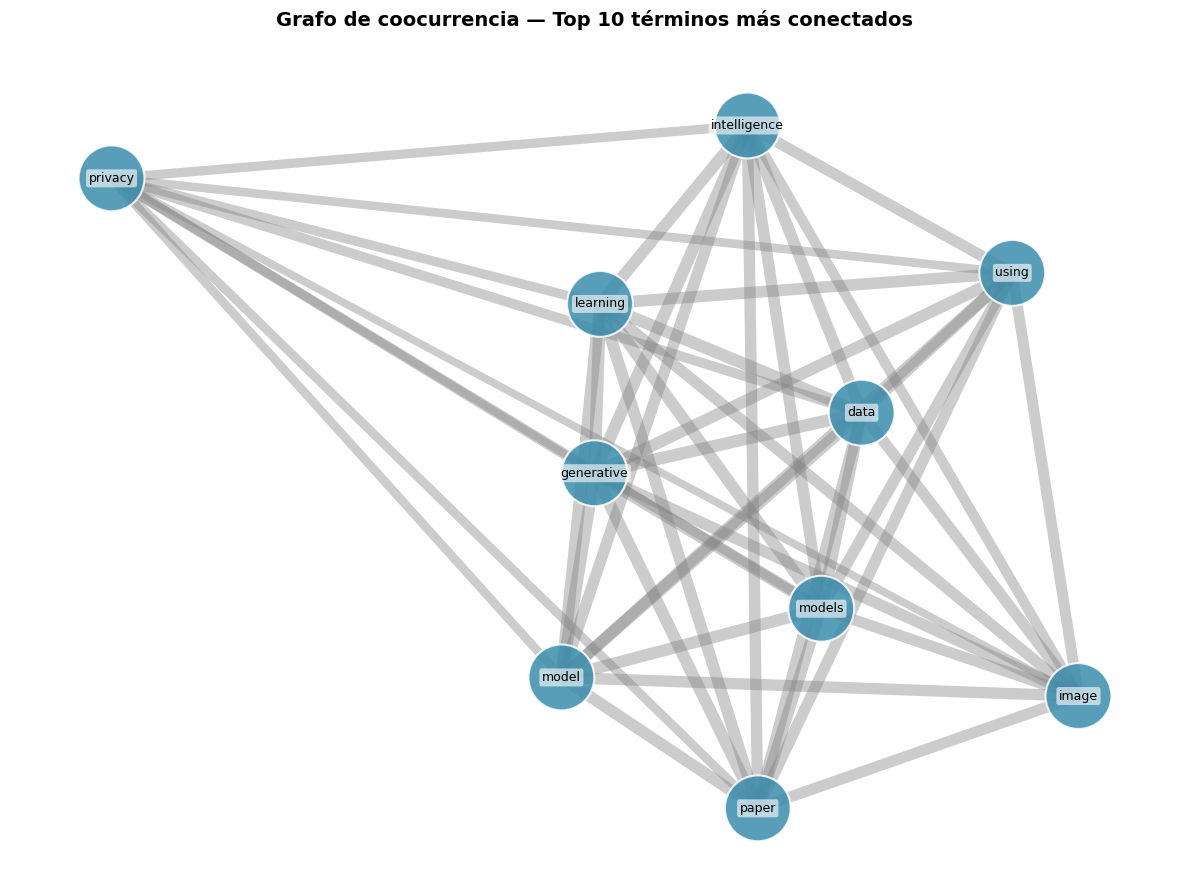

In [ ]:
# Mostrar resumen de los términos más conectados
print('Resumen - top términos por grado:')
display(df_summary.head(20))

# Subgrafo con los top N términos más conectados
topN = 10                                             # Aqui es donde delimitamso si mostramso 10 o 20 o 30 ......
top_terms = df_summary.head(topN)["term"].tolist()
subG = G.subgraph(top_terms).copy()

# Calcular posiciones de los nodos (más estables y separados)
pos = nx.spring_layout(subG, seed=42, k=0.8, iterations=100)

# Tamaño de nodos según el grado
node_sizes = [00 + 250 * subG.degree(n) for n in subG.nodes()]

# Grosor de aristas según peso (más fino = relación débil, más grueso = fuerte)
edge_widths = [1 + math.log1p(d["weight"]) for _, _, d in subG.edges(data=True)]

# Crear figura
plt.figure(figsize=(12, 9))
plt.title(f"Grafo de coocurrencia — Top {topN} términos más conectados", fontsize=14, weight='bold', pad=20)

# Nodos en color azul suave y semitransparentes
nx.draw_networkx_nodes(
    subG, pos,
    node_size=node_sizes,
    node_color="#3C8DAD",
    alpha=0.85,
    edgecolors="white",
    linewidths=1.5,
)

# Aristas en gris con transparencia
nx.draw_networkx_edges(
    subG, pos,
    width=edge_widths,
    edge_color="gray",
    alpha=0.4,
)

# Etiquetas legibles con fondo translúcido blanco
nx.draw_networkx_labels(
    subG, pos,
    font_size=9,
    font_color="black",
    bbox=dict(facecolor="white", edgecolor="none", alpha=0.6, boxstyle="round,pad=0.2")
)

plt.axis("off")
plt.tight_layout()
plt.show()


